In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from math import ceil

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Carga de datos
# ==============================================================================
aep_hourly = pd.read_csv('AEP_hourly.csv')
energy_consumption = pd.read_csv('Energy_consumption.csv')
vgsales = pd.read_csv('vgsales.csv')

In [3]:
vgsales

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37
...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,Kemco,0.01,0.00,0.00,0.00,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003.0,Shooter,Infogrames,0.01,0.00,0.00,0.00,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,Activision,0.00,0.00,0.00,0.00,0.01
16596,16599,Know How 2,DS,2010.0,Puzzle,7G//AMES,0.00,0.01,0.00,0.00,0.01


In [4]:
vgsales.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Cargar el dataset
df = pd.read_csv('vgsales.csv')

# Seleccionar características y etiquetas
features = ['Platform', 'Year', 'Genre', 'Publisher']
target = 'Global_Sales'

X = df[features]
y = df[target]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocesamiento y pipeline
numeric_features = ['Year']
categorical_features = ['Platform', 'Genre', 'Publisher']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Modelos base
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', xgb.XGBRegressor(random_state=42))
]

# Meta-modelo
meta_model = Ridge()

# Crear el stacking regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('stacking_model', stacking_model)
])

# Optimización de hiperparámetros con búsqueda en grid (reducido)
param_grid = {
    'stacking_model__rf__n_estimators': [100, 200],
    'stacking_model__rf__max_depth': [6, 8],
    'stacking_model__rf__min_samples_split': [50],
    'stacking_model__rf__min_samples_leaf': [5],
    'stacking_model__gb__n_estimators': [100],
    'stacking_model__gb__learning_rate': [0.01],
    'stacking_model__gb__max_depth': [3],
    'stacking_model__xgb__n_estimators': [100],
    'stacking_model__xgb__learning_rate': [0.01],
    'stacking_model__xgb__max_depth': [3]
}



In [29]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results = {
    'Best Parameters': grid_search.best_params_,
    'MSE': mse,
    'R^2': r2
}

print(results)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'Best Parameters': {'stacking_model__gb__learning_rate': 0.01, 'stacking_model__gb__max_depth': 3, 'stacking_model__gb__n_estimators': 100, 'stacking_model__rf__max_depth': 8, 'stacking_model__rf__min_samples_leaf': 5, 'stacking_model__rf__min_samples_split': 50, 'stacking_model__rf__n_estimators': 100, 'stacking_model__xgb__learning_rate': 0.01, 'stacking_model__xgb__max_depth': 3, 'stacking_model__xgb__n_estimators': 100}, 'MSE': 3.828080951408851, 'R^2': 0.08884805675767715}


In [5]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [6]:
vgsales = vgsales.dropna(subset=['Year', 'Genre', 'Publisher'])
vgsales['Year'] = vgsales['Year'].astype(int)

In [7]:
vgsales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16291 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16291 non-null  int64  
 1   Name          16291 non-null  object 
 2   Platform      16291 non-null  object 
 3   Year          16291 non-null  int32  
 4   Genre         16291 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16291 non-null  float64
 7   EU_Sales      16291 non-null  float64
 8   JP_Sales      16291 non-null  float64
 9   Other_Sales   16291 non-null  float64
 10  Global_Sales  16291 non-null  float64
dtypes: float64(5), int32(1), int64(1), object(4)
memory usage: 1.4+ MB


In [8]:
vgsales.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,16291.0,8290.190228,4792.654450,1.00,4132.50,8292.00,12439.50,16600.00
Year,16291.0,2006.405561,5.832412,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16291.0,0.265647,0.822432,0.00,0.00,0.08,0.24,41.49
EU_Sales,16291.0,0.147731,0.509303,0.00,0.00,0.02,0.11,29.02
JP_Sales,16291.0,0.078833,0.311879,0.00,0.00,0.00,0.04,10.22
Other_Sales,16291.0,0.048426,0.190083,0.00,0.00,0.01,0.04,10.57
Global_Sales,16291.0,0.540910,1.567345,0.01,0.06,0.17,0.48,82.74


In [9]:
# Exploración de datos
sns.pairplot(vgsales_data, x_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Year'], y_vars='Global_Sales', height=4, aspect=0.7, kind='reg')
plt.show()

# Filtrar solo las columnas numéricas
numerical_data = vgsales_data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year']]

# Calcular la correlación
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


NameError: name 'vgsales_data' is not defined

In [10]:
features = ['Platform', 'Year', 'Genre', 'Publisher']
X = vgsales[features]
y = vgsales['Global_Sales']

In [11]:
categorical_features = ['Platform', 'Genre', 'Publisher']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

In [14]:
ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Platform', 'Genre',
                                                   'Publisher'])])),
                ('regressor', Ridge())])

In [15]:
# Predicción
y_pred_linear = ridge_model.predict(X_test)

# Evaluación del modelo
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_linear, r2_linear

(3.901639298199148, 0.08796897829173755)

In [16]:
# Modelo de Lasso Regression
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1))
])

# Entrenamiento del modelo de Lasso
lasso_model.fit(X_train, y_train)

# Predicción con Lasso
y_pred_lasso = lasso_model.predict(X_test)

# Evaluación del modelo de Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print('Lasso Regression - MSE:', mse_lasso, 'R2:', r2_lasso)

Lasso Regression - MSE: 4.274634068143579 R2: 0.0007792677305196172


In [17]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('Random Forest - MSE:', mse_rf, 'R2:', r2_rf)

Random Forest - MSE: 4.133378788559975 R2: 0.03379851608076623


In [18]:
# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred_rf = rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print('Random Forest (Entrenamiento) - MSE:', mse_train_rf, 'R2:', r2_train_rf)
print('Random Forest (Prueba) - MSE:', mse_rf, 'R2:', r2_rf)

Random Forest (Entrenamiento) - MSE: 0.7261701520305236 R2: 0.6370336734420525
Random Forest (Prueba) - MSE: 4.133378788559975 R2: 0.03379851608076623


In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

In [20]:
# Crear el modelo de Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [22]:
# Definir el grid de parámetros para buscar
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, 20],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}


In [23]:
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Platform',
                                                                          'Genre',
                                                                          'Publisher'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, 20],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='r2', verbose=2)

In [24]:
best_rf_model = grid_search.best_estimator_

# Predicción con el mejor modelo
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluación del mejor modelo
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print('Best Random Forest - MSE:', mse_best_rf, 'R2:', r2_best_rf)
print('Best Random Forest - Best Parameters:', grid_search.best_params_)

Best Random Forest - MSE: 3.9509208275147136 R2: 0.07644913237626116
Best Random Forest - Best Parameters: {'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}


In [21]:
from sklearn.ensemble import GradientBoostingRegressor

# Crear el modelo de Gradient Boosting
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42))
])

# Entrenar el modelo de Gradient Boosting
gb_model.fit(X_train, y_train)

# Predicción con Gradient Boosting
y_pred_gb = gb_model.predict(X_test)

# Evaluación del modelo de Gradient Boosting
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print('Gradient Boosting - MSE:', mse_gb, 'R2:', r2_gb)


Gradient Boosting - MSE: 3.894268714456903 R2: 0.08969189538049271


In [ ]:
from sklearn.model_selection import cross_val_score

# Validación cruzada para Random Forest
rf_cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
print('Random Forest CV Scores:', rf_cv_scores)
print('Random Forest CV Mean R2:', rf_cv_scores.mean())

# Validación cruzada para Gradient Boosting
gb_cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='r2')
print('Gradient Boosting CV Scores:', gb_cv_scores)
print('Gradient Boosting CV Mean R2:', gb_cv_scores.mean())


Random Forest CV Scores: [-3.03955000e-01 -4.02019527e+00 -8.18683499e+01 -3.56014558e+02
 -1.03798013e+03]
Random Forest CV Mean R2: -296.0374377850245
Gradient Boosting CV Scores: [  -0.22780654   -8.35999392  -13.89344008  -27.61725227 -187.31884019]
Gradient Boosting CV Mean R2: -47.483466602108


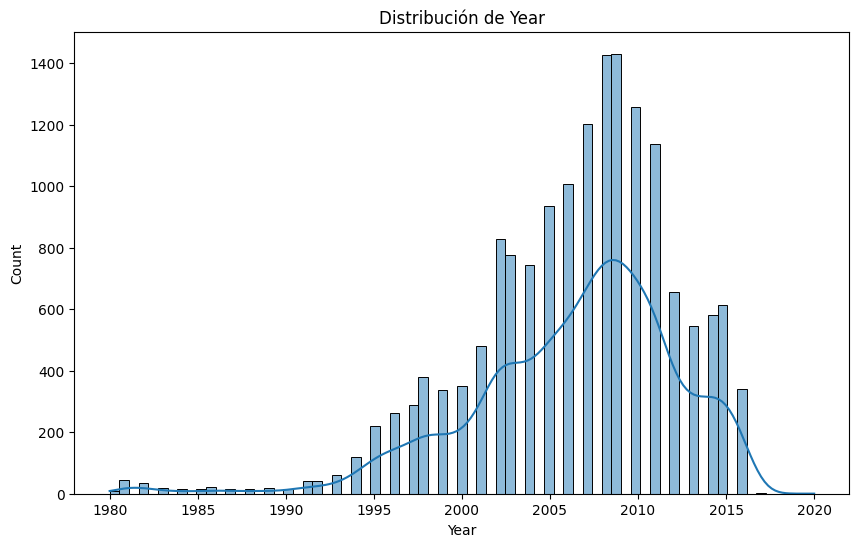

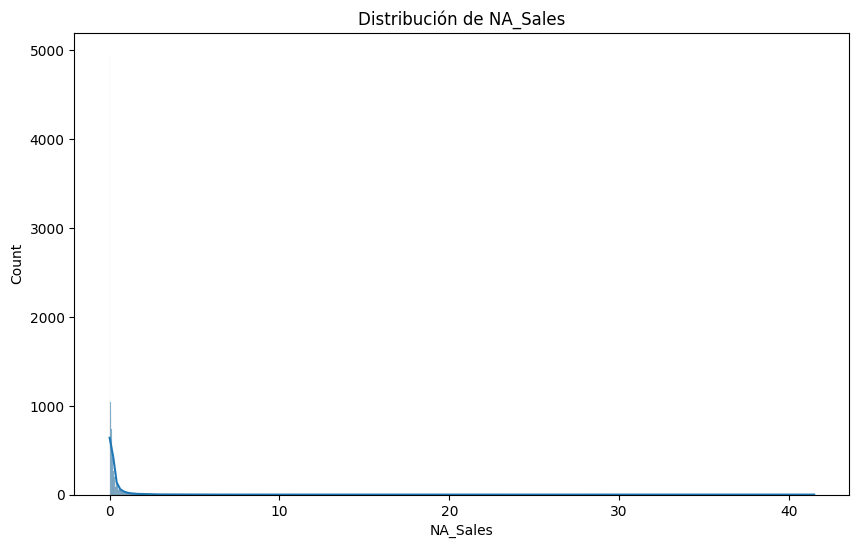

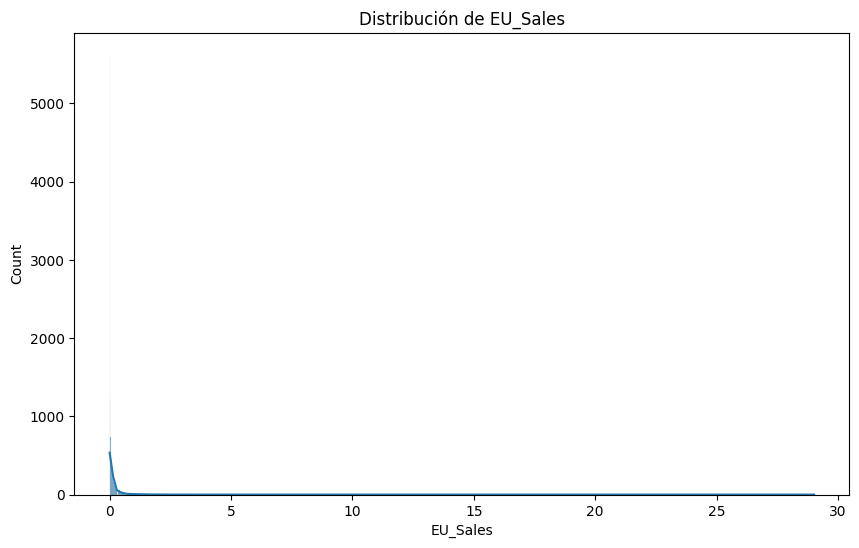

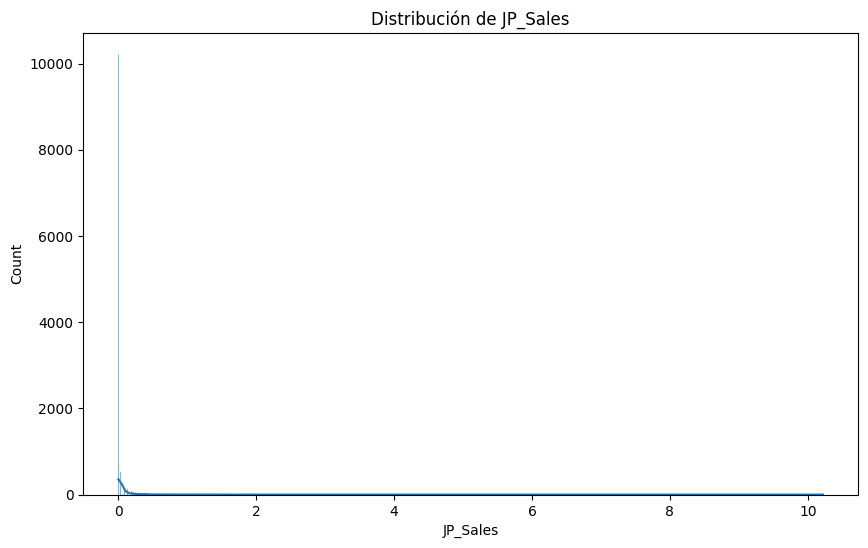

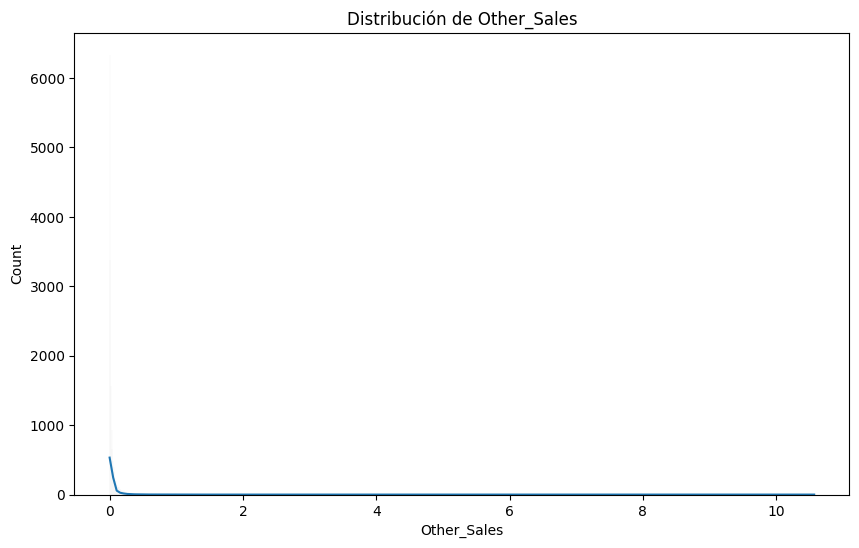

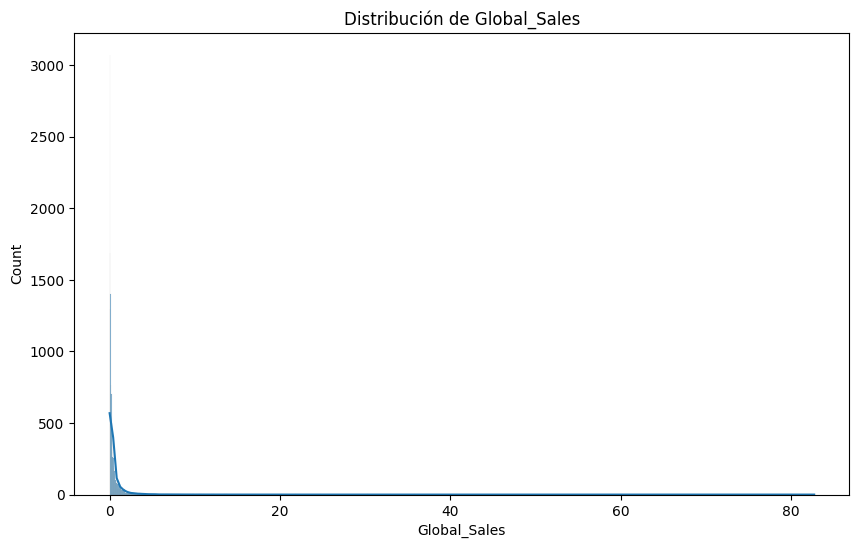

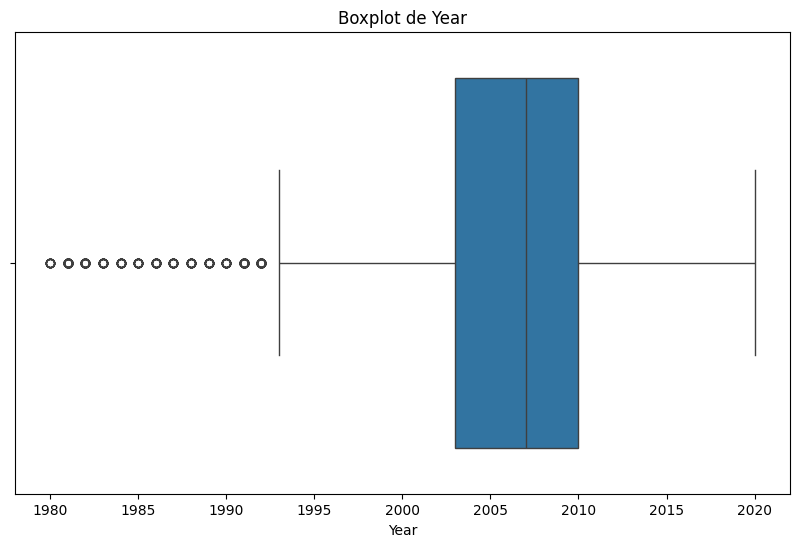

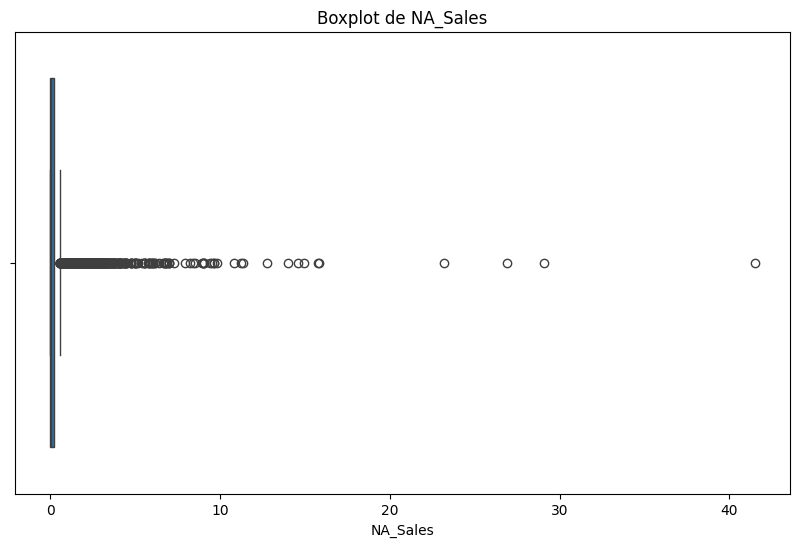

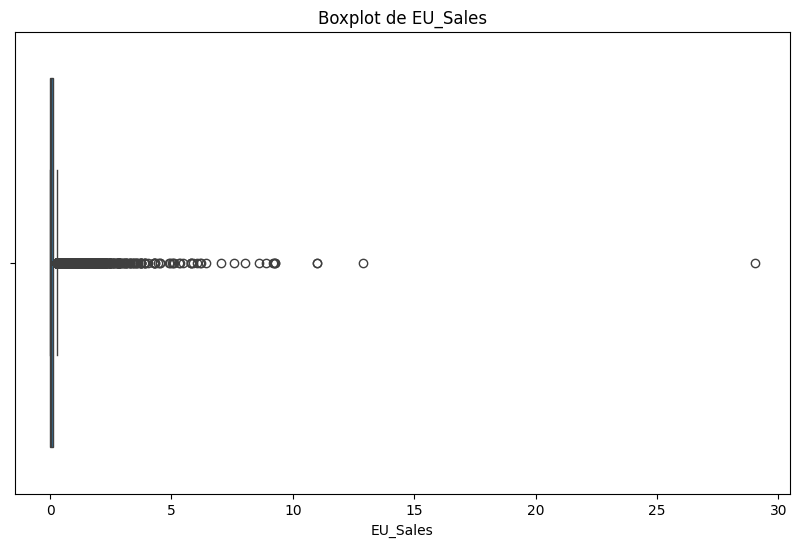

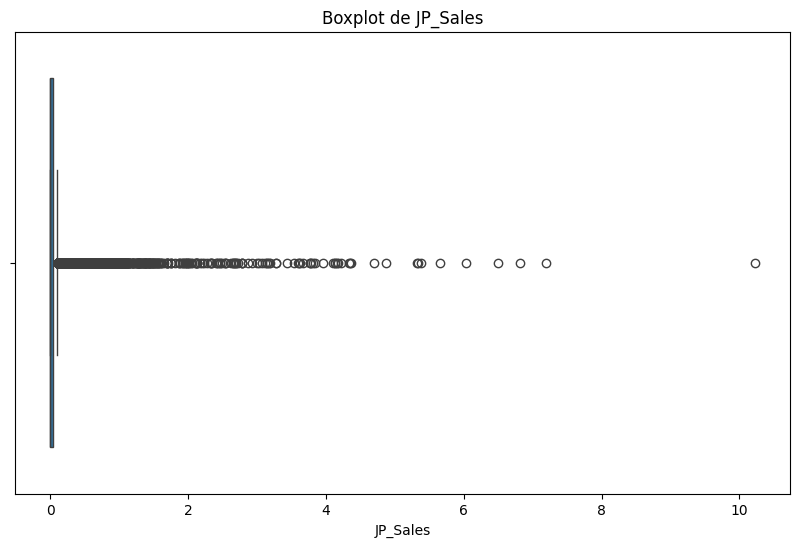

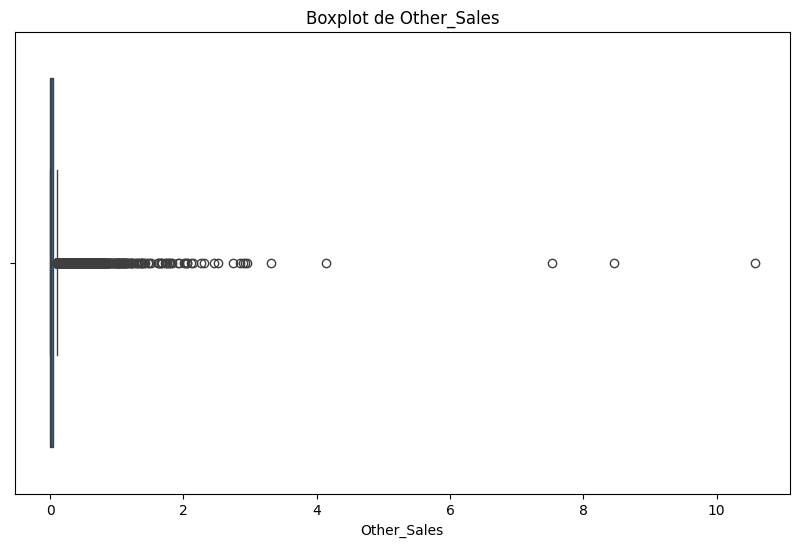

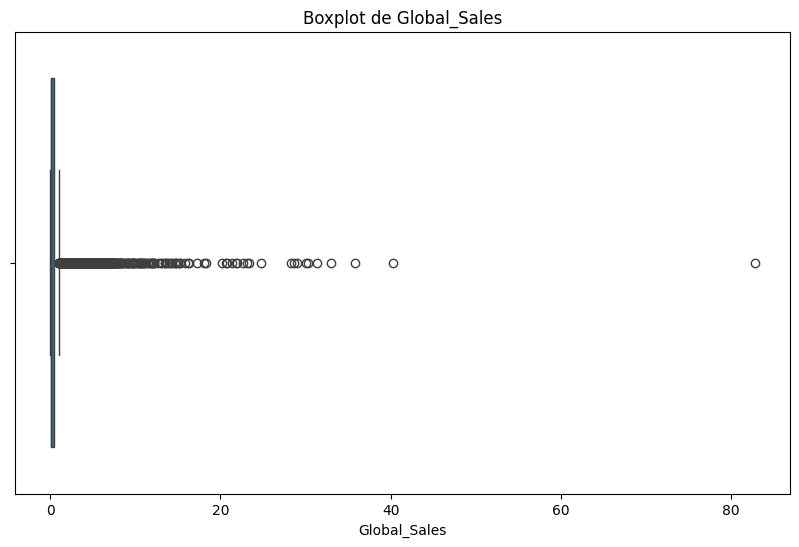

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Revisar la distribución de las características numéricas
num_features = ['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(vgsales_data[feature], kde=True)
    plt.title(f'Distribución de {feature}')
    plt.show()

# Buscar outliers usando boxplots
for feature in num_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=vgsales_data[feature])
    plt.title(f'Boxplot de {feature}')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Cargar los datos
vgsales_data = pd.read_csv('vgsales.csv')

# Revisión de los datos
print(vgsales_data.head())
print(vgsales_data.info())

# Limpieza de datos
vgsales_data = vgsales_data.dropna(subset=['Year', 'Genre', 'Publisher'])
vgsales_data['Year'] = vgsales_data['Year'].astype(int)

# Selección de características y variable objetivo
features = ['Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
X = vgsales_data[features]
y = vgsales_data['Global_Sales']

# Preprocesamiento de datos
categorical_features = ['Platform', 'Genre', 'Publisher']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Random Forest
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('Random Forest - MSE:', mse_rf, 'R2:', r2_rf)

# Grid Search para Random Forest
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print('Best Random Forest - MSE:', mse_best_rf, 'R2:', r2_best_rf)

# Modelo de Gradient Boosting
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42))
])
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print('Gradient Boosting - MSE:', mse_gb, 'R2:', r2_gb)


   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las importancias de las características del modelo de Gradient Boosting
importances = gb_model.named_steps['regressor'].feature_importances_
feature_names = preprocessor.transformers_[0][1]['onehot'].get_feature_names_out(categorical_features)
feature_names = np.append(feature_names, X_train.columns[-4:])

# Crear un dataframe para las importancias de las características
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualización de las importancias de las características
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características en el Modelo de Gradient Boosting')
plt.gca().invert_yaxis()
plt.show()


ValueError: All arrays must be of the same length

In [ ]:
aep_hourly

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [ ]:
energy_consumption

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732
...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-11 11:00:00,28.619382,48.850160,1080.087000,5,Off,Off,21.194696,Saturday,No,82.306692
996,2022-02-11 12:00:00,23.836647,47.256435,1705.235156,4,Off,On,25.748176,Tuesday,Yes,66.577320
997,2022-02-11 13:00:00,23.005340,48.720501,1320.285281,6,Off,On,0.297079,Friday,Yes,72.753471
998,2022-02-11 14:00:00,25.138365,31.306459,1309.079719,3,On,Off,20.425163,Thursday,Yes,76.950389


In [ ]:
# Convertir columnas de tiempo a tipo datetime
aep_hourly['Datetime'] = pd.to_datetime(aep_hourly['Datetime'])
energy_consumption['Timestamp'] = pd.to_datetime(energy_consumption['Timestamp'])

# Verificar valores faltantes
aep_hourly.isnull().sum(), energy_consumption.isnull().sum()


(Datetime    0
 AEP_MW      0
 dtype: int64,
 Timestamp            0
 Temperature          0
 Humidity             0
 SquareFootage        0
 Occupancy            0
 HVACUsage            0
 LightingUsage        0
 RenewableEnergy      0
 DayOfWeek            0
 Holiday              0
 EnergyConsumption    0
 dtype: int64)

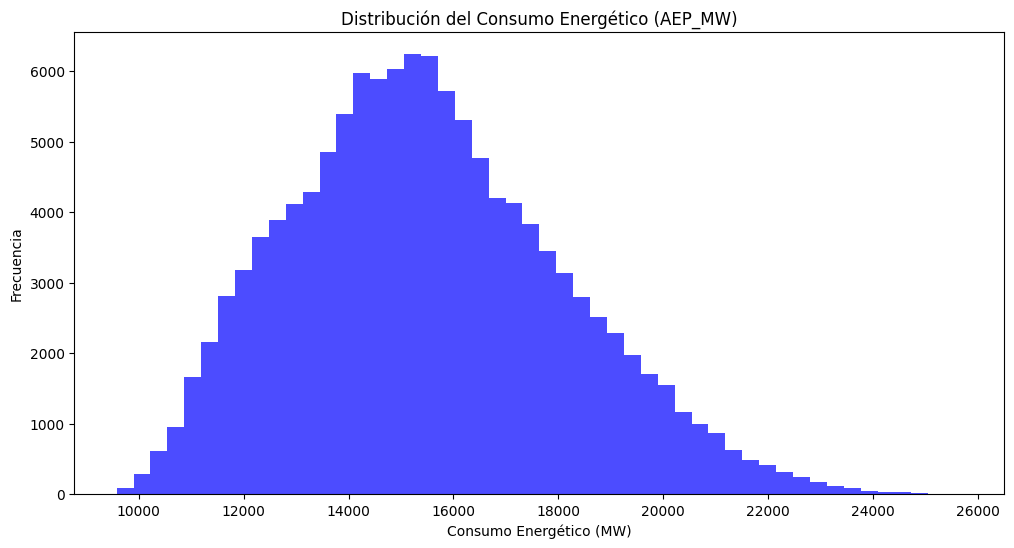

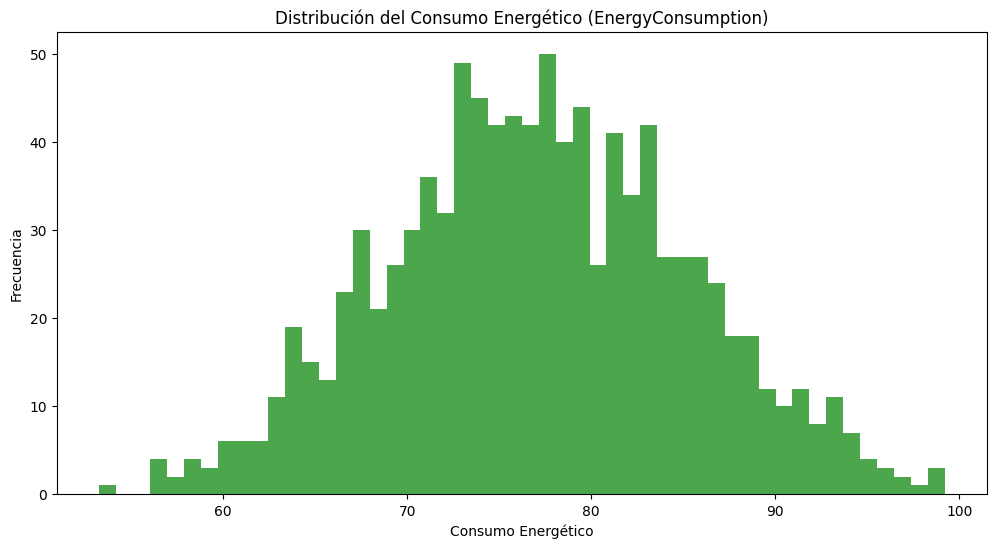

In [ ]:
import matplotlib.pyplot as plt

# Distribución del consumo energético en AEP_hourly.csv
plt.figure(figsize=(12, 6))
plt.hist(aep_hourly['AEP_MW'], bins=50, color='blue', alpha=0.7)
plt.title('Distribución del Consumo Energético (AEP_MW)')
plt.xlabel('Consumo Energético (MW)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución del consumo energético en Energy_consumption.csv
plt.figure(figsize=(12, 6))
plt.hist(energy_consumption['EnergyConsumption'], bins=50, color='green', alpha=0.7)
plt.title('Distribución del Consumo Energético (EnergyConsumption)')
plt.xlabel('Consumo Energético')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Seleccionar características y la variable objetivo
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy']
X = energy_consumption[features]
y = energy_consumption['EnergyConsumption']

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5977.1763 - val_loss: 5876.1084
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5799.8062 - val_loss: 5674.4590
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5617.1792 - val_loss: 5352.8877
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5256.8008 - val_loss: 4871.2646
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4670.4834 - val_loss: 4219.3569
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3992.7351 - val_loss: 3396.5945
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3147.5371 - val_loss: 2471.8171
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2213.8530 - val_loss: 1565.0784
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1334.8484 - val_loss: 839.2297
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 686.2761 - val_loss: 401.0409
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 334.1119 - val_loss: 217.3217
E

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model with a different learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with more epochs
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5955.8779 - val_loss: 5879.3032
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5722.7314 - val_loss: 5444.6060
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5232.6626 - val_loss: 4050.6206
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3442.2786 - val_loss: 1327.4874
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 896.0353 - val_loss: 257.4472
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 340.2651 - val_loss: 186.7193
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 230.7531 - val_loss: 178.7685
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 219.6991 - val_loss: 169.2954
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 205.2977 - val_loss: 163.4560
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 210.5174 - val_loss: 156.6110
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 196.8782 - val_loss: 149.0840
Epoch 12/20

In [ ]:
# Make predictions
y_pred_nn = model.predict(X_test_scaled)

# Evaluate the model
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f'MSE of the Neural Network model: {mse_nn}')
print(f'R^2 of the Neural Network model: {r2_nn}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MSE of the Neural Network model: 35.334908941299126
R^2 of the Neural Network model: 0.46053471626241793


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Seleccionar características y la variable objetivo
features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy']
X = energy_consumption[features]
y = energy_consumption['EnergyConsumption']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = linear_model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2


(31.976268559331174, 0.5118117660955122)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf = rf_model.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf


(38.78415409808443, 0.40787438479596727)

In [ ]:
# Definir la búsqueda de hiperparámetros para Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear y entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Evaluar el mejor modelo
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f'MSE del mejor modelo: {mse_best_rf}')
print(f'R^2 del mejor modelo: {r2_best_rf}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
MSE del mejor modelo: 36.090725660617174
R^2 del mejor modelo: 0.44899550778114294


In [ ]:
# Feature importance for Random Forest
rf_importances = best_rf_model.feature_importances_
rf_importances

array([0.7402748 , 0.08840565, 0.09108617, 0.08023337])

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Create and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [ ]:
# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'MSE of the Gradient Boosting model: {mse_gb}')
print(f'R^2 of the Gradient Boosting model: {r2_gb}')


MSE of the Gradient Boosting model: 36.60190807681812
R^2 of the Gradient Boosting model: 0.4411911812536393


In [ ]:
# Feature importance for Gradient Boosting
gb_importances = gb_model.feature_importances_

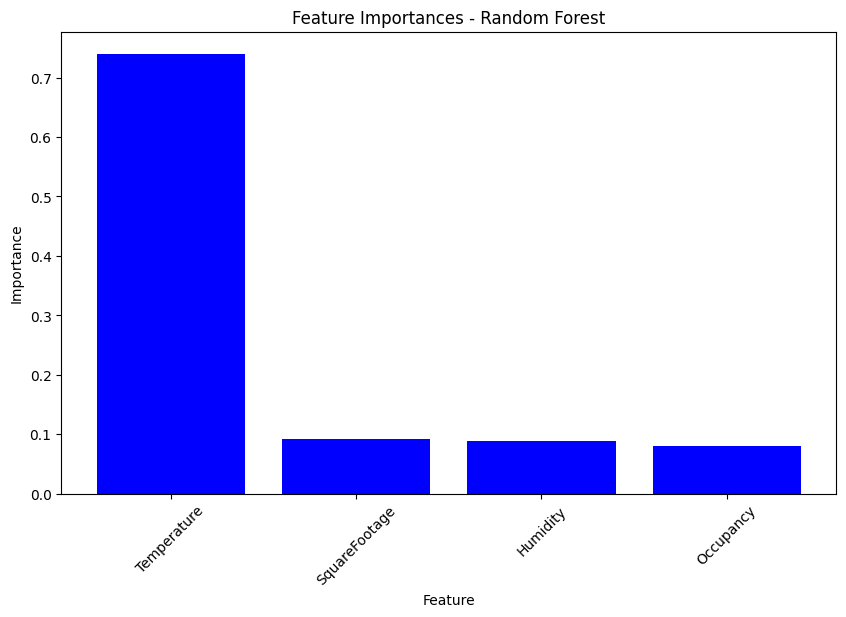

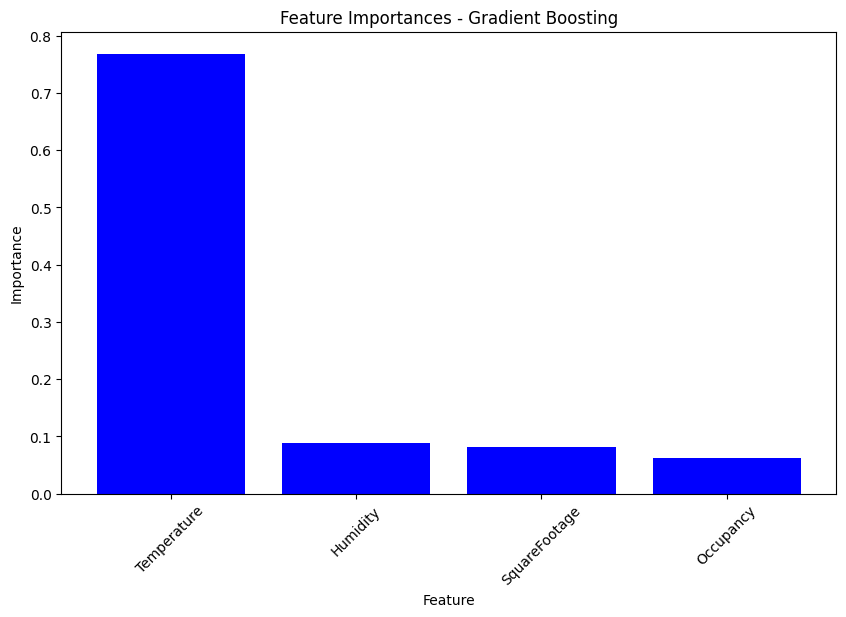

In [ ]:
# Function to plot feature importances
def plot_feature_importance(importances, feature_names, model_name):
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importances - {model_name}')
    plt.bar(range(len(importances)), importances[indices], color='b', align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

# Plot feature importances for Random Forest
plot_feature_importance(rf_importances, features, 'Random Forest')

# Plot feature importances for Gradient Boosting
plot_feature_importance(gb_importances, features, 'Gradient Boosting')


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Modelos a evaluar
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

# Evaluación con validación cruzada
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    print(f'{name} - Mean MSE: {mse_scores.mean():.2f}, Std MSE: {mse_scores.std():.2f}')


Linear Regression - Mean MSE: 31.78, Std MSE: 1.70
Random Forest - Mean MSE: 35.30, Std MSE: 2.09
Gradient Boosting - Mean MSE: 35.39, Std MSE: 2.99
Neural Network - Mean MSE: 37.54, Std MSE: 3.11


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [ ]:
# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('nn', Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))]))
]

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_model.predict(X_test)

# Evaluate the model
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f'MSE of the Stacking model: {mse_stacking}')
print(f'R^2 of the Stacking model: {r2_stacking}')

MSE of the Stacking model: 35.2776955284225
R^2 of the Stacking model: 0.46140820514171177


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [6, 7, 8, 9],
    'min_samples_split': [50, 60, 70],
    'min_samples_leaf': [ 5]
}

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f'MSE of the best Random Forest model: {mse_best_rf}')
print(f'R^2 of the best Random Forest model: {r2_best_rf}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 300}
Best score: 0.49687431284409717
MSE of the best Random Forest model: 34.28981753052172
R^2 of the best Random Forest model: 0.4764903406389617
